<a href="https://colab.research.google.com/github/anubhav48/Catboost-vs-Lightboost-vs-XGBoost-vs-Snapboost/blob/master/HPO_Categorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install xgboost --quiet
!pip install catboost --quiet
!pip install lightgbm --quiet
!pip install hyperopt --quiet

In [7]:
import warnings
warnings.filterwarnings("ignore")
# Importing Dependencies
import numpy as np
import pandas as pd
import sys
import os
from datetime import datetime
import matplotlib as mpl
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from catboost import Pool,CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

In [8]:
input_path = 'https://raw.githubusercontent.com/anubhav48/Comparison/master/pokemon_categorical.csv'

In [9]:
pokemon_df = pd.read_csv(input_path)

In [11]:
#basic info of dataset
df2 = pokemon_df.select_dtypes(include = ['float64', 'int64'])
df3 = pokemon_df.select_dtypes(include = ['object'])
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   abilities          801 non-null    object 
 1   against_bug        801 non-null    float64
 2   against_dark       801 non-null    float64
 3   against_dragon     801 non-null    float64
 4   against_electric   801 non-null    float64
 5   against_fairy      801 non-null    float64
 6   against_fight      801 non-null    float64
 7   against_fire       801 non-null    float64
 8   against_flying     801 non-null    float64
 9   against_ghost      801 non-null    float64
 10  against_grass      801 non-null    float64
 11  against_ground     801 non-null    float64
 12  against_ice        801 non-null    float64
 13  against_normal     801 non-null    float64
 14  against_poison     801 non-null    float64
 15  against_psychic    801 non-null    float64
 16  against_rock       801 non

In [12]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   against_bug        801 non-null    float64
 1   against_dark       801 non-null    float64
 2   against_dragon     801 non-null    float64
 3   against_electric   801 non-null    float64
 4   against_fairy      801 non-null    float64
 5   against_fight      801 non-null    float64
 6   against_fire       801 non-null    float64
 7   against_flying     801 non-null    float64
 8   against_ghost      801 non-null    float64
 9   against_grass      801 non-null    float64
 10  against_ground     801 non-null    float64
 11  against_ice        801 non-null    float64
 12  against_normal     801 non-null    float64
 13  against_poison     801 non-null    float64
 14  against_psychic    801 non-null    float64
 15  against_rock       801 non-null    float64
 16  against_steel      801 non

In [13]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   abilities      801 non-null    object
 1   classfication  801 non-null    object
 2   japanese_name  801 non-null    object
 3   name           801 non-null    object
 4   type1          801 non-null    object
 5   type2          417 non-null    object
dtypes: object(6)
memory usage: 37.7+ KB


In [14]:
df3.head()

,abilities,classfication,japanese_name,name,type1,type2
0,"['Overgrow', 'Chlorophyll']",Seed Pokémon,Fushigidaneフシギダネ,Bulbasaur,grass,poison
1,"['Overgrow', 'Chlorophyll']",Seed Pokémon,Fushigisouフシギソウ,Ivysaur,grass,poison
2,"['Overgrow', 'Chlorophyll']",Seed Pokémon,Fushigibanaフシギバナ,Venusaur,grass,poison
3,"['Blaze', 'Solar Power']",Lizard Pokémon,Hitokageヒトカゲ,Charmander,fire,NaN
4,"['Blaze', 'Solar Power']",Flame Pokémon,Lizardoリザード,Charmeleon,fire,NaN


In [15]:
## from preprocessing, use LabelEncoder, we want to encode 
from sklearn import preprocessing 
le = preprocessing.LabelEncoder() 
labels = le.fit_transform(pokemon_df['type1'])
print(len(le.classes_)) 
print(le.classes_)

18
['bug' 'dark' 'dragon' 'electric' 'fairy' 'fighting' 'fire' 'flying'
 'ghost' 'grass' 'ground' 'ice' 'normal' 'poison' 'psychic' 'rock' 'steel'
 'water']


water       114
normal      105
grass        78
bug          72
psychic      53
fire         52
rock         45
electric     39
ground       32
poison       32
dark         29
fighting     28
ghost        27
dragon       27
steel        24
ice          23
fairy        18
flying        3
Name: type1, dtype: int64

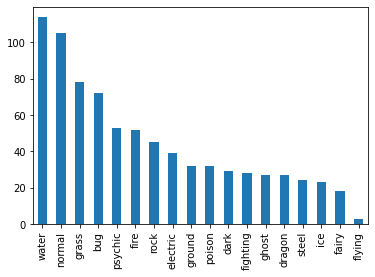

In [16]:
pokemon_df.type1.value_counts().plot.bar()
pokemon_df.type1.value_counts() 

flying      95
poison      34
ground      34
fairy       29
psychic     29
fighting    25
steel       22
dark        21
grass       20
water       17
dragon      17
ice         15
ghost       14
rock        14
fire        13
electric     9
bug          5
normal       4
Name: type2, dtype: int64

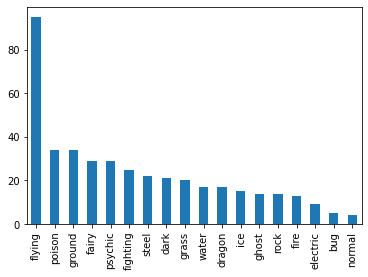

In [17]:
pokemon_df.type2.value_counts().plot.bar()
pokemon_df.type2.value_counts() 

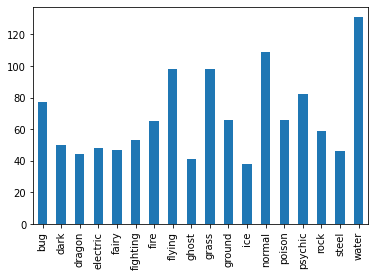

In [18]:
# and the accurate plot, keep in mind not every pokemon has 2 types
(pokemon_df.type1.value_counts() + pokemon_df.type2.value_counts()).plot.bar()
## and the accurate plot, keep in mind not every pokemon has 2 types
(pokemon_df.type1.value_counts() + pokemon_df.type2.value_counts()).plot.bar()

In [19]:
pokemon_df['type2'].fillna(value='None', inplace=True) 

In [20]:
abilitiesList = []
for n in range(len(pokemon_df.abilities)):
    for ability in pokemon_df.abilities.iloc[n]:
        if ability not in abilitiesList:
            abilitiesList.append(ability)
            
print('Number of unique abilities: ', len(abilitiesList))

Number of unique abilities:  56


In [21]:
data = {
    'attack': pokemon_df['attack'],
    'defense': pokemon_df['defense'],
    'sp_attack': pokemon_df['sp_attack'],
    'sp_defense': pokemon_df['sp_defense'],
    'type2': pokemon_df.type2,
    'type1': pokemon_df['type1']
}
data = pd.DataFrame(data)
## look for columns with 'against' and join them
data = pokemon_df.filter(like='against').join(data) 

X = data.drop('type1', axis=1)
y = data['type1']
print(list(X))
X

['against_bug', 'against_dark', 'against_dragon', 'against_electric', 'against_fairy', 'against_fight', 'against_fire', 'against_flying', 'against_ghost', 'against_grass', 'against_ground', 'against_ice', 'against_normal', 'against_poison', 'against_psychic', 'against_rock', 'against_steel', 'against_water', 'attack', 'defense', 'sp_attack', 'sp_defense', 'type2']


,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,against_grass,against_ground,against_ice,against_normal,against_poison,against_psychic,against_rock,against_steel,against_water,attack,defense,sp_attack,sp_defense,type2
0,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,49,49,65,65,poison
1,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,62,63,80,80,poison
2,1.00,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,0.25,1.0,2.0,1.0,1.0,2.0,1.0,1.0,0.5,100,123,122,120,poison
3,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,52,43,60,50,None
4,0.50,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,0.50,2.0,0.5,1.0,1.0,1.0,2.0,0.5,2.0,64,58,80,65,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,0.25,1.0,0.5,2.0,0.5,1.0,2.0,0.5,1.0,0.25,0.0,1.0,0.5,0.0,0.5,1.0,0.5,1.0,101,103,107,101,flying
797,1.00,1.0,0.5,0.5,0.5,2.0,4.0,1.0,1.0,0.25,1.0,1.0,0.5,0.0,0.5,0.5,0.5,0.5,181,131,59,31,steel
798,2.00,0.5,2.0,0.5,4.0,2.0,0.5,1.0,0.5,0.50,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.5,101,53,97,53,dragon
799,2.00,2.0,1.0,1.0,1.0,0.5,1.0,1.0,2.0,1.00,1.0,1.0,1.0,1.0,0.5,1.0,1.0,1.0,107,101,127,89,None


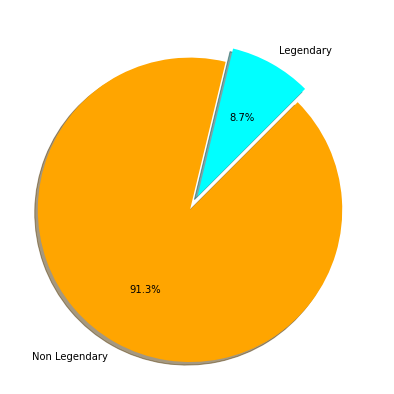

In [22]:
fig = plt.figure(figsize=(7,7))

colors = ["aqua", "orange"]
pokeLeg = pokemon_df[pokemon_df['is_legendary'] == True]
pokeNon = pokemon_df[pokemon_df['is_legendary'] == False]

legDist = [pokeLeg['name'].count(), pokeNon['name'].count()]
legPie = plt.pie(legDist,
                 labels= ['Legendary', 'Non Legendary'], 
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))

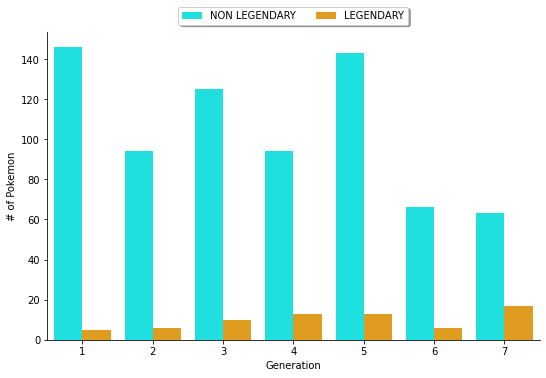

In [23]:
## correlation between legendary pokemon and non-legendary per generation
colors = ["aqua", "orange"]
g = sns.factorplot(
    x='generation', 
    data=pokemon_df,
    kind='count', 
    hue='is_legendary',
    palette=colors, 
    size=5, 
    aspect=1.5,
    legend=False,
    ).set_axis_labels('Generation', '# of Pokemon')

g.ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),  shadow=True, ncol=2, labels=['NON LEGENDARY','LEGENDARY'])
plt.show()

In [24]:
## Not usually a good sign since there is not enough data on what is a legendary
## Maybe there's a very strong correlation we can exploit
## High attack and defense correlation

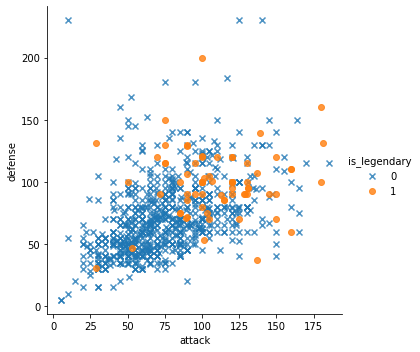

In [25]:
sns.lmplot(x='attack', y='defense', hue='is_legendary', fit_reg=False, data=pokemon_df, markers = ['x', 'o'])

In [26]:
leg = pokemon_df[pokemon_df['is_legendary'] == True]
leg_total = leg['base_total'].mean()
non_leg_total = pokemon_df[pokemon_df['is_legendary'] != True]['base_total'].mean()

In [27]:
pd.DataFrame([leg_total, non_leg_total], index=['Legendary', 'non-Legendary'], columns=['Average Total'])

,Average Total
Legendary,615.257143
non-Legendary,410.481532


In [28]:
isLegendary = pd.get_dummies(pokemon_df['is_legendary'], drop_first=True)
lr_df = pokemon_df[['base_total', 'capture_rate']]
lr_df = pd.concat([lr_df, isLegendary], axis=1)

In [29]:
lr_df.columns = ['Base Total', 'Catch Rate', 'Is Legendary']
lr_df.head()

,Base Total,Catch Rate,Is Legendary
0,318,45,0
1,405,45,0
2,625,45,0
3,309,45,0
4,405,45,0


In [30]:
lr_df.tail()

,Base Total,Catch Rate,Is Legendary
796,570,25,1
797,570,255,1
798,570,15,1
799,600,3,1
800,600,3,1


In [31]:
X = lr_df.drop('Is Legendary', axis = 1)
y = lr_df['Is Legendary']

In [32]:
#trying to predict the is legendary from base total and catch rate

# Training and Testing

In [33]:
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3)

### 1. LightGBM Algorithm on the Dataset




In [34]:
lgb_hps = { 'num_leaves': hp.choice('num_leaves',np.arange(100, 200, 10, dtype=int)),
            'max_depth': hp.choice('max_depth',np.arange(5, 16, 1, dtype=int)),
            'n_estimators': hp.quniform('n_estimators', 10, 700, 1),
            'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
            'bagging_fraction': hp.uniform('bagging_fraction', 0.75, 1.0),
            'learning_rate': hp.loguniform('learning_rate', -5.0, -2.3),
            'lambda_l1': hp.uniform('lambda_l1', 0, 10),
            'lambda_l2': hp.uniform('lambda_l2', 0, 10)
          }

num_leaves_list = [100,110,120,130,140,150,160,170,180,190,200]

In [35]:
accuracy_list_lgbm = []
def HPO_lgbm(lgb_hps):
    num_round = 50
    train_data=lgb.Dataset(x_train,label=y_train)
    lgbm=lgb.train(lgb_hps,train_data,num_round)
    ypred2=lgbm.predict(x_test)
    accuracy_lgbm = roc_auc_score(y_test,ypred2).mean()
    accuracy_list_lgbm.append(accuracy_lgbm)
    return {'loss': -accuracy_lgbm, 'status': STATUS_OK }

In [36]:
trials = Trials()
best_lgbm = fmin(fn= HPO_lgbm,
            space= lgb_hps,
            algo= tpe.suggest,
            max_evals = 80,
            trials = trials
            )
max_acc_lgbm = max(accuracy_list_lgbm)
print("Best Hyperparameters for LGBM are: \n")
best_lgbm

100%|██████████| 80/80 [00:14<00:00,  5.42it/s, best loss: -0.9902714932126696]
Best Hyperparameters for LGBM are: 



{'bagging_fraction': 0.7512763132242419,
 'feature_fraction': 0.7899908350005923,
 'lambda_l1': 0.002964853075263091,
 'lambda_l2': 9.550141726827476,
 'learning_rate': 0.05915278197507036,
 'max_depth': 5,
 'n_estimators': 636.0,
 'num_leaves': 8}

##### Hyper-Parameters Vs. Accuracy Graphs

Best num_leaves   =   8
Best max_depth   =   5
Best n_estimators   =   636.0
Best feature_fraction   =   0.7899908350005923
Best bagging_fraction   =   0.7512763132242419
Best learning_rate   =   0.05915278197507036
Best lambda_l1   =   0.002964853075263091
Best lambda_l2   =   9.550141726827476


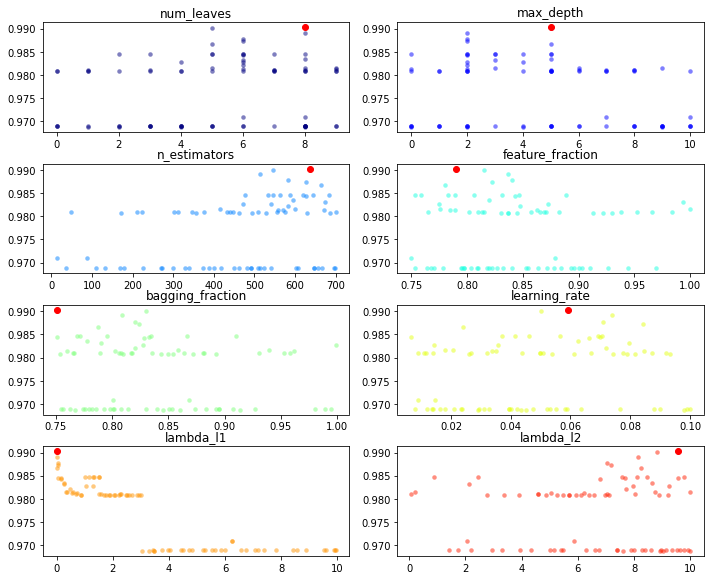

In [37]:
parameters = ['num_leaves','max_depth','n_estimators','feature_fraction','bagging_fraction','learning_rate','lambda_l1','lambda_l2']
f, axes = plt.subplots(nrows=4, ncols=2, figsize=(10,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    print("Best " + str(val) + "   =   " + str(best_lgbm[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_lgbm[val],max_acc_lgbm,color = "red")
    axes[i//2,i%2].set_title(val)

In [38]:
params = { 
            'num_leaves': num_leaves_list[best_lgbm['num_leaves']],
            'max_depth': best_lgbm['max_depth'],
            'n_estimators': best_lgbm['n_estimators'],
            'feature_fraction':best_lgbm['feature_fraction'],
            'bagging_fraction':best_lgbm['bagging_fraction'],
            'learning_rate':best_lgbm['learning_rate'],
            'lambda_l1': best_lgbm['lambda_l1'],
            'lambda_l2':best_lgbm['lambda_l2']
          }
train_data=lgb.Dataset(x_train,label=y_train)

num_round=100
t1=datetime.now()
lgbm=lgb.train(params,train_data,num_round)
t2=datetime.now()
execution_time_lgbm = t2-t1
t3 = datetime.now()
ypred2=lgbm.predict(x_test)
t4 = datetime.now()

for i in range(0,len(ypred2)): 
    if ypred2[i] >=0.5:
        ypred2[i] = 1
    else:
        ypred2[i] = 0
accuracy_lgbm = round(accuracy_score(ypred2,y_test),5)
print("Accuracy score = ",accuracy_lgbm*100,"%")
print("Execution time = ",execution_time_lgbm)
print("Prediction time = ",t4-t3)
lgbm_train_time = t2-t1

Accuracy score =  98.75500000000001 %
Execution time =  0:00:00.357571
Prediction time =  0:00:00.007701


### 2. CatBoost Algorithm on the Dataset

#### HyperParameter Optimization with Hyperopt

In [39]:
cb_hps = {  
            'learning_rate':      hp.loguniform('learning_rate', -5.0, -2.3),
            'depth':              hp.choice('depth',np.arange(5,16,1,dtype = int)),
            'l2_leaf_reg':       hp.quniform('l2_leaf_reg',2, 16, 1),
            'random_seed':       hp.choice('random_seed',np.arange(5, 10, 1,dtype=int)),
            'colsample_bylevel': hp.quniform('colsample_bylevel',0.3, 0.8, 0.1),
            'n_estimators':      hp.choice('n_estimators',np.arange(100,160,10,dtype = int))
        }

depth_list = [i for i in range(5,16,1)]
est_list = [i for i in range(100,160,10)]

In [40]:
accuracy_list_cb = []
cat_features = np.where(x_train.dtypes!=float)[0]
def HPO_cb(cb_hps):
    num_round = 50
    model = CatBoostClassifier(**cb_hps,silent = True)
    model.fit(x_train,y_train,cat_features = cat_features)
    pred = model.predict_proba(x_test)[:,1]
    accuracy_cb = roc_auc_score(y_test,pred).mean()
    accuracy_list_cb.append(accuracy_cb)
    return {'loss': -accuracy_cb, 'status': STATUS_OK }

In [41]:
trials = Trials()
best_cb = fmin(fn= HPO_cb,
            space= cb_hps,
            algo= tpe.suggest,
            max_evals = 10,
            trials = trials
            )
max_acc_cb = max(accuracy_list_cb)
print("Best Hyperparameters for CatBoost are: \n")
best_cb

100%|██████████| 10/10 [00:00<00:00, 10.15it/s, best loss: -0.9742081447963801]
Best Hyperparameters for CatBoost are: 



{'colsample_bylevel': 0.8,
 'depth': 2,
 'l2_leaf_reg': 6.0,
 'learning_rate': 0.011254736771005401,
 'n_estimators': 2,
 'random_seed': 2}

##### Hyper-Parameters Vs. Accuracy Graphs

Best n_estimators   =   120
Best random_seed   =   7
Best learning_rate   =   0.011254736771005401
Best depth   =   7
Best l2_leaf_reg   =   6.0
Best colsample_bylevel   =   0.8


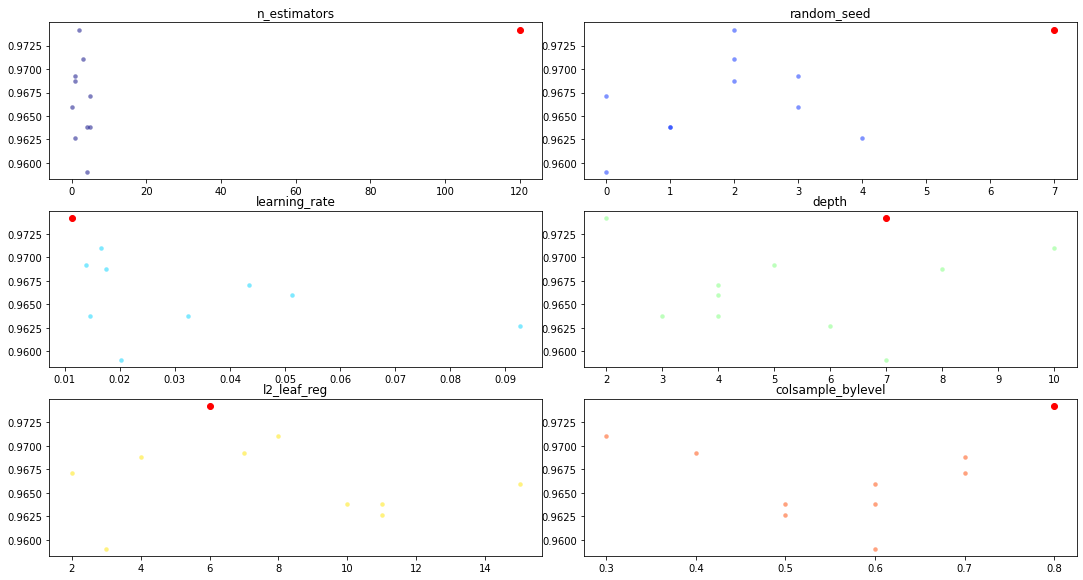

In [42]:
parameters = ['n_estimators','random_seed','learning_rate','depth','l2_leaf_reg','colsample_bylevel']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'depth':
      best_cb[val] = depth_list[best_cb[val]]
    elif val == 'n_estimators':
      best_cb[val] = est_list[best_cb['n_estimators']]
    elif val == 'random_seed':
      best_cb[val]+=5
    print("Best " + str(val) + "   =   " + str(best_cb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_cb[val],max_acc_cb,color = "red")
    axes[i//2,i%2].set_title(val)

#### Actual Training on CatBoost with chosen HPs

In [43]:
cat_features = np.where(x_train.dtypes!=float)[0]
model = CatBoostClassifier(      
                                  n_estimators = best_cb['n_estimators'],
                                  colsample_bylevel = best_cb['colsample_bylevel'],
                                  learning_rate = best_cb['learning_rate'],
                                  l2_leaf_reg = best_cb['l2_leaf_reg'], 
                                  random_seed = best_cb['random_seed'],
                                  depth = best_cb['depth'],
                                  silent = True
                           )
t1=datetime.now()
model.fit(x_train,y_train,cat_features = cat_features)
t2=datetime.now()
execution_time_cat_boost = t2-t1
t3 = datetime.now()
pred = model.predict_proba(x_test)[:,1]
t4 = datetime.now()
accuracy_cat_boost = round(roc_auc_score(y_test,pred),5)
print("Accuracy score = ",accuracy_cat_boost*100,"%")
print("Execution time = ",execution_time_cat_boost)
print("Prediction time = ",t4-t3)
cat_boost_train_time = t2-t1

Accuracy score =  97.421 %
Execution time =  0:00:00.106610
Prediction time =  0:00:00.000975


### 3. XGBoost Algorithm on the Dataset

#### HyperParameter Optimization with Hyperopt

In [44]:
xgb_hps = {  
            'learning_rate':     hp.loguniform('learning_rate', -5.0, -2.3),
            'max_depth':         hp.choice('max_depth',np.arange(5,16,1,dtype = int)),
            'lambda':            hp.quniform('lambda',2, 16, 1),
            'subsample':        hp.quniform('subsample',0.1,1.0,0.1),
            'colsample_bytree': hp.quniform('colsample_bytree',0.3, 0.8, 0.1),
            'min_split_loss' : hp.quniform('min_split_loss',0.1,2.0,0.1)
        }

depth_list = [i for i in range(5,16,1)]

In [45]:
accuracy_list_xgb = []
def HPO_xgb(xgb_hps):
    model = model = XGBClassifier(**xgb_hps)
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    accuracy_xgb = accuracy_score(y_pred,y_test).mean()
    accuracy_list_xgb.append(accuracy_xgb)
    return {'loss': -accuracy_xgb, 'status': STATUS_OK }

In [46]:
trials = Trials()
best_xgb = fmin(fn= HPO_xgb,
            space= xgb_hps,
            algo= tpe.suggest,
            max_evals = 80,
            trials = trials
            )
max_acc_xgb = max(accuracy_list_xgb)
print("Best Hyperparameters for XGBoost are: \n")
best_xgb

100%|██████████| 80/80 [00:03<00:00, 20.68it/s, best loss: -0.995850622406639]
Best Hyperparameters for XGBoost are: 



{'colsample_bytree': 0.30000000000000004,
 'lambda': 2.0,
 'learning_rate': 0.029710330752237578,
 'max_depth': 7,
 'min_split_loss': 1.9000000000000001,
 'subsample': 0.9}

##### Hyper-Parameters Vs. Accuracy Graphs

Best max_depth   =   12
Best subsample   =   0.9
Best learning_rate   =   0.029710330752237578
Best min_split_loss   =   1.9000000000000001
Best lambda   =   2.0
Best colsample_bytree   =   0.30000000000000004


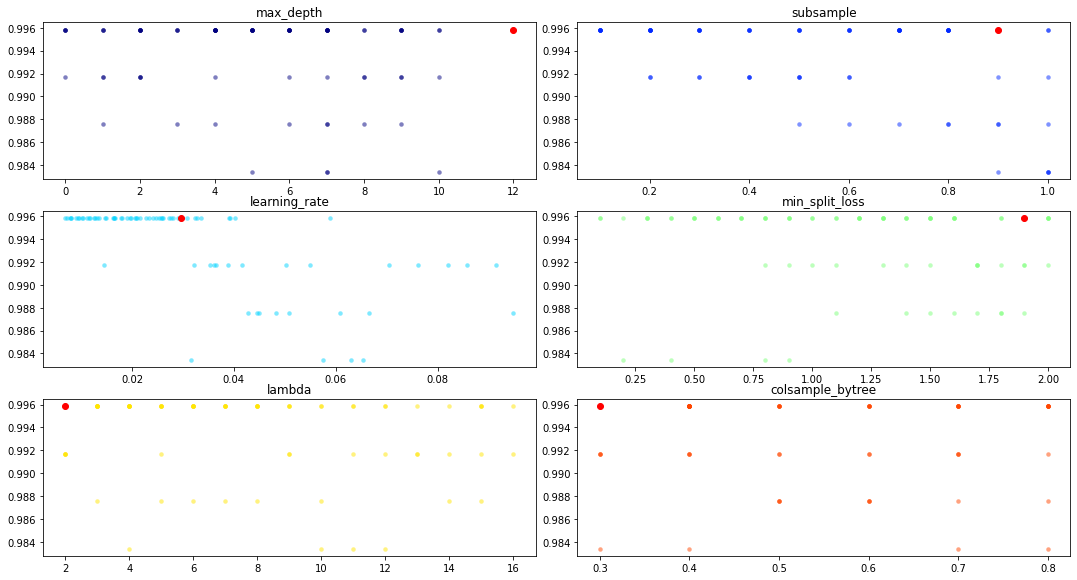

In [47]:
parameters = ['max_depth','subsample','learning_rate','min_split_loss','lambda','colsample_bytree']
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,8))
f.tight_layout()
cmap = plt.cm.jet
for i, val in enumerate(parameters):
    if val == 'max_depth':
      best_xgb[val] = depth_list[best_xgb[val]]
    print("Best " + str(val) + "   =   " + str(best_xgb[val]))
    xs = np.array([t['misc']['vals'][val] for t in trials.trials]).ravel()
    ys = [-t['result']['loss'] for t in trials.trials]
    xs, ys = zip(*sorted(zip(xs, ys)))
    ys = np.array(ys)
    c=np.array(cmap(float(i)/len(parameters)))
    axes[i//2,i%2].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.5, c=c.reshape(1,-1))
    axes[i//2,i%2].scatter(best_xgb[val],max_acc_xgb,color = "red")
    axes[i//2,i%2].set_title(val)

In [48]:
model = XGBClassifier(**best_xgb)
t1=datetime.now()
model.fit(x_train,y_train)
t2=datetime.now()
execution_time_xgb = t2-t1
t3 = datetime.now()
y_pred = model.predict(x_test)
t4 = datetime.now()
predictions = [round(value) for value in y_pred]
accuracy_xgb = round(accuracy_score(y_pred,y_test),5)
print("Accuracy score = ",accuracy_xgb*100,"%")
print("Execution time = ",execution_time_xgb)
print("Prediction time = ",t4-t3)
xgb_train_time = t2-t1

Accuracy score =  99.58500000000001 %
Execution time =  0:00:00.033714
Prediction time =  0:00:00.001709


# Results and Plots

### 1. Accuracy Plot

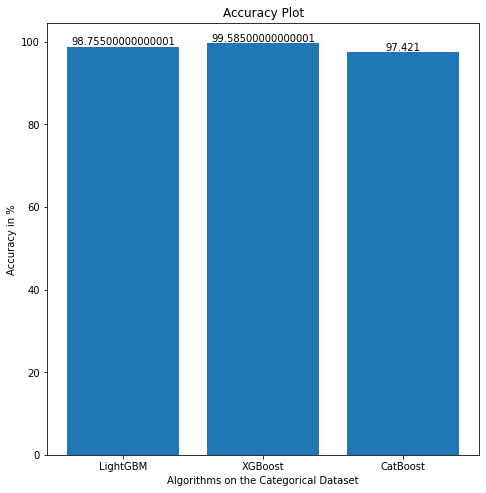

In [50]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (6,6))
ax = fig.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
accuracy = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
g = ax.bar(algorithms,accuracy)
plt.title("Accuracy Plot")
plt.xlabel("Algorithms on the Categorical Dataset")
plt.ylabel("Accuracy in %")
bar_label = [accuracy_lgbm*100, accuracy_xgb*100,accuracy_cat_boost*100]
def autolabel(rects):
    for idx,rect in enumerate(g):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel(g)
plt.show()

### 2. Training Time  Plot

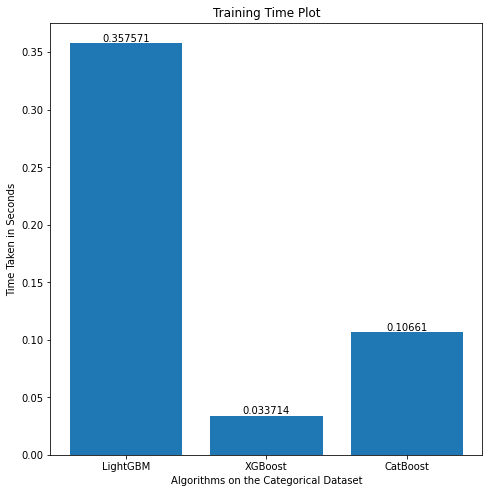

In [51]:
lg = float(str(lgbm_train_time)[5:])
cb = float(str(cat_boost_train_time)[5:])
xgb = float(str(xgb_train_time)[5:])
fig1 = plt.figure(figsize = (6,6))
ay = fig1.add_axes([0,0,1,1])
algorithms = ['LightGBM','XGBoost','CatBoost']
training_time = [lg,xgb,cb]
g1 = ay.bar(algorithms,training_time)
plt.title("Training Time Plot")
plt.xlabel("Algorithms on the Categorical Dataset")
plt.ylabel("Time Taken in Seconds")
bar_label = training_time
def autolabel1(rects):
    for idx,rect in enumerate(g1):
        height = rect.get_height()
        ay.text(rect.get_x() + rect.get_width()/2., 1.0*height,
                bar_label[idx],
                ha='center', va='bottom', rotation=0)

autolabel1(g1)
plt.show()